# This notebook is for experimenting with the model configuration. Refer to predictions.py to view the actual code for the REST API

In [135]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [136]:
# Load the csv data
df = pd.read_csv('data/AMZN.csv')
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Mean,Max,Min
751,2022-12-23,83.250000,85.779999,82.930000,85.250000,85.250000,57433700,0.1779,0.7351,-0.3818
752,2022-12-27,84.970001,85.349998,83.000000,83.040001,83.040001,57284000,0.1677,0.7845,-0.2782
753,2022-12-28,82.800003,83.480003,81.690002,81.820000,81.820000,58228600,0.1908,0.6124,-0.2960
754,2022-12-29,82.870003,84.550003,82.550003,84.180000,84.180000,54995900,0.2225,0.8111,-0.5994
755,2022-12-30,83.120003,84.050003,82.470001,84.000000,84.000000,62401200,0.1447,0.7096,-0.7184


In [137]:
# Separate & convert dates to datatime objects for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.head(10))

0   2020-01-02
1   2020-01-03
2   2020-01-06
3   2020-01-07
4   2020-01-08
5   2020-01-09
6   2020-01-10
7   2020-01-13
8   2020-01-14
9   2020-01-15
Name: Date, dtype: datetime64[ns]


In [138]:
# Extract the variables for training
data_cols = df[['Open', 'Close', 'Mean', 'Max', 'Min']]
training_df = data_cols.astype(float)
training_df

,Open,Close,Mean,Max,Min
0,93.750000,94.900497,0.0000,0.0000,0.0000
1,93.224998,93.748497,0.0000,0.0000,0.0000
2,93.000000,95.143997,0.7096,0.7096,0.7096
3,95.224998,95.343002,-0.7717,-0.7717,-0.7717
4,94.902000,94.598503,0.0000,0.0000,0.0000
...,...,...,...,...,...
751,83.250000,85.250000,0.1779,0.7351,-0.3818
752,84.970001,83.040001,0.1677,0.7845,-0.2782
753,82.800003,81.820000,0.1908,0.6124,-0.2960
754,82.870003,84.180000,0.2225,0.8111,-0.5994


In [139]:
scaler = StandardScaler()
scaler = scaler.fit(training_df)
scaled_data_df = scaler.transform(training_df)

In [195]:
trainX, trainY = [], [] # Sets containing data used for prediction and the predicted values

n_future = 1 # Number of days we want to predict future values
n_past = 10 # Number of previous days we use to predict future values

# Transform the data into its corresponding sets for the LSTM model
for i in range(n_past, len(scaled_data_df) - n_future +1):
    trainX.append(scaled_data_df[i - n_past:i, 0:training_df.shape[1]])
    trainY.append(scaled_data_df[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY) # Convert to numpy arrays

print(f"TrainX data shape: {trainX.shape}")
print(f"TrainY data shape: {trainY.shape}")


TrainX data shape: (746, 10, 5)
TrainY data shape: (746, 1)


In [200]:
# Define the Autoencoder model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_74 (LSTM)              (None, 10, 64)            17920     
                                                                 
 lstm_75 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_37 (Dropout)        (None, 32)                0         
                                                                 
 dense_37 (Dense)            (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/60
21/21 [==============================] - 1s 17ms/step - loss: 0.4332 - val_loss: 0.7309
Epoch 2/60
21/21 [==============================] - 0s 6ms/step - loss: 0.1214 - val_loss: 0.1766
Epoch 3/60
21/21 [==============================] - 0s 6ms/step - loss: 0.0849 - val_loss: 0.0594
Epoch 4/60
21/21 [==============================] - 0s 6ms/step - loss: 0.0846 - val_loss: 0.0918
Epoch 5/60
21/21 [==============================] - 0s 7ms/step - loss: 0.0705 - val_loss: 0.1000
Epoch 6/60
21/21 [==============================] - 0s 7ms/step - loss: 0.0701 - val_loss: 0.1073
Epoch 7/60
21/21 [==============================] - 0s 7ms/step - loss: 0.0565 - val_loss: 0.1040
Epoch 8/60
21/21 [==============================] - 0s 7ms/step - loss: 0.0517 - val_loss: 0.1354
Epoch 9/60
21/21 [==============================] - 0s 7ms/step - loss: 0.0509 - val_loss: 0.0886
Epoch 10/60
21/21 [==============================] - 0s 7ms/step - loss: 0.0526 - val_loss: 0.0458
Epoch 11/60
21/21 

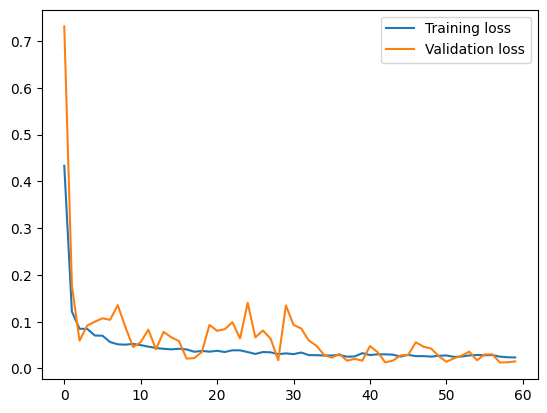

In [201]:
# Fit the model
history = model.fit(trainX, trainY, epochs=60, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


In [202]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Extract the business days in the US only for predicting
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

n_past_days = 16
n_days_for_prediction = 15  # Predict for the past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
predict_period_dates

# Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:])

# Convert into the proper shape by copying the predict data 5x to perform inverse transform and retrive actual values
prediction_copies = np.repeat(prediction, training_df.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
y_pred_future

1/1 [==============================] - 0s 174ms/step


array([87.3862  , 87.381424, 89.15364 , 90.81048 , 87.9645  , 85.99318 ,
       84.07797 , 82.892105, 82.608116, 83.561356, 80.32538 , 79.39623 ,
       79.19056 , 76.98349 , 79.77963 ], dtype=float32)

<Axes: xlabel='Date', ylabel='Open'>

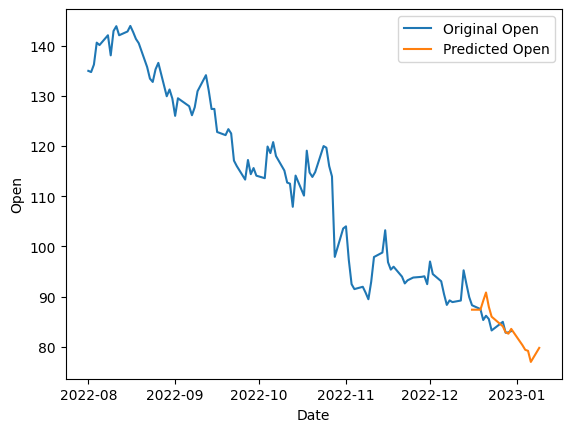

In [203]:
# Convert timestamp to date
forecast_dates = [time_i.date() for time_i in predict_period_dates]

forecast_df = pd.DataFrame({'Date': np.array(forecast_dates), 'Predicted Open': y_pred_future})
forecast_df['Date'] = pd.to_datetime(forecast_df['Date'])

original = df[['Date', 'Open']].copy()
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2022-08-01']

plot_data = pd.concat([original[['Date', 'Open']], forecast_df[['Date', 'Predicted Open']]])

# Create a line plot using the concatenated data
sns.lineplot(x='Date', y='Open', data=plot_data, label='Original Open')
sns.lineplot(x='Date', y='Predicted Open', data=plot_data, label='Predicted Open')